IBM Employee Attrition Analysis
---
Author: 이동경
Date: April 15 2023

이 프로젝트에서는 직원 Record를 이용해 해당 직원의 이탈 여부를 예측하는 XGBoost 분석 모형을 만들고, LIME 및 SHAP를 이용하여 각각의 예측 결과값과 분석 모형으로부터 인사이트를 찾아보도록 하겠습니다. 아래의 데이터는 IBM Data Science 팀에서 제공한 자료입니다. 데이터에서 각각의 record는 해당 직원의 feature 값을 기록하고 있으며, target 변수인 Attrition은 직원의 퇴사 여부를 나타냅니다 (0: 근무 중, 1: 퇴사). 

In [1]:
import pandas as pd
import numpy as np
hr = pd.read_csv("~/Downloads/dkl_portfolio/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# drop unncessary features
hr = hr.drop(['DailyRate',  # MonthlyIncome contains related info
              'HourlyRate', 
              'MonthlyRate', 
              'EmployeeNumber', 
              'EmployeeCount', 
              'Over18', # All employees are over 18 and work 40 hours a week
              'StandardHours'], axis = 1)
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EnvironmentSatisfaction   1470 non-null   int64 
 8   Gender                    1470 non-null   object
 9   JobInvolvement            1470 non-null   int64 
 10  JobLevel                  1470 non-null   int64 
 11  JobRole                   1470 non-null   object
 12  JobSatisfaction           1470 non-null   int64 
 13  MaritalStatus             1470 non-null   object
 14  MonthlyIncome           

Feature 값들의 정의는 아래와 같습니다.
 
 * Age: 나이
 * Attrition: 퇴사 여부, 'Yes' 'No'
 * BusinessTravel: 출장 빈도, 'Non Travel' 'Travel Rarely' 'Travel Frequently'
 * Department: 근무 부서, 'Human Resources' 'Research & Development' 'Sales'
 * DistanceFromHome: 통근 거리
 * Education: 최종 학력, {1:'Below College', 2:'College', 3:'Bachelor', 4:'Master', 5:'Doctor'}
 * EducationField: 학위 분야, 'Human Resources' 'Life Sciences' 'Marketing' 'Medical' 'Technical Degree' 'Other'
 * EnvironmentSatisfaction: 근무 환경 만족도, {1:'Low', 2:'Medium', 3:'High', 4:'Very High'} 
 * Gender: 성별, 'Male' 'Female'
 * JobInvolvement: 직무 참여 수준, {1:'Low', 2:'Medium', 3:'High', 4:'Very High'}
 * JobLevel: 직급, 1, 2, 3, 4, 5
 * JobRole: 직무, 'Healthcare Representative' 'Human Resources' 'Laboratory Technician' 'Manager' 'Manufacturing Director' 'Research Director' 'Research Scientist' 'Sales Executive' 'Sales Representative'
 * JobSatisfaction: 직무 수행 만족도, {1:'Low', 2:'Medium', 3:'High', 4:'Very High'}
 * MaritalStatus: 기혼 여부, 'Single' 'Married' 'Divorced'
 * MonthlyIncome: 급여
 * NumCompaniesWorked: 과거 재직하였던 직장의 수
 * OverTime: 연장근무 여부, 'Yes' 'No'
 * PercentSalaryHike: 급여 인상율
 * PerformanceRating: 직무 성취도, {1:'Low', 2:'Good', 3:'Excellent' 4:'Outstanding'}
 * RelationshipSatisfaction: 직장 내 대인관계 만족도, {1:'Low', 2:'Medium', 3:'High', 4:'Very High'}
 * StockOptionLevel: 스톡옵션 레벨, 0, 1, 2, 3
 * TotalWorkingYears: 총 경력
 * TrainingTimesLastYear: 작년에 받은 직무교육 횟수
 * WorkLifeBalance: 일과 삶의 균형, {1:'Bad' 2:'Good' 3:'Better' 4:'Best'}
 * YearsAtCompany: 근속년수
 * YearsInCurrentRole: 현재 직무 근속년수
 * YearsSinceLastPromotion: 진급일로 부터의 햇수
 * YearsWithCurrManager: 현재 Manager와 함께 근무한 햇수

# Data Preparations

Model fitting에 앞서 categorical feature의 encoding을 진행하도록 하겠습니다.

## Label Encoding

Feature 중에서 Boolean value를 갖는 Attrition, OverTime에 대해서는 Label encoding을 진행하여 값이 Yes인 경우 1로, No인 경우 0으로 재정의 하겠습니다. 

In [2]:
from sklearn.preprocessing import LabelEncoder

# create a LabelEncoder object
le = LabelEncoder()

le.fit(hr['Attrition'])
le.fit(hr['OverTime'])

LabelEncoder()

In [3]:
hr['Attrition'] = le.transform(hr['Attrition'])
hr['OverTime'] = le.transform(hr['OverTime'])

데이터에서 Gender는 두 가지 값만을 가질 수 있습니다. 따라서 Label encoding을 진행하도록 하겠습니다.

In [4]:
hr['Gender'] = le.fit_transform(hr['Gender'])

나머지 범주형 자료들 중, feature value의 order가 명확한 BusinessTravel에 대해서도 역시 Label encoding을 진행하겠습니다.

In [5]:
hr['BusinessTravel'] = le.fit_transform(hr['BusinessTravel'])

## One-Hot Encoding

범주형 feature들 중, Department, EducationField, JobRole, MaritalStatus는 value level사이에 명확한 order를 찾기 어렵습니다. 따라서 One-hot encoding을 진행하도록 하겠습니다.

In [6]:
from sklearn.preprocessing import OneHotEncoder

# one-hot encodings
# define the list of columns to one-hot encode
columns_to_encode = ['Department', 'EducationField', 'JobRole', 'MaritalStatus']

# Create a OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore')

# Perform one-hot encoding for each column and concatenate the results
encoded_dfs = []
for col in columns_to_encode:
    encoded = pd.DataFrame(encoder.fit_transform(hr[[col]]).toarray(), 
    columns=[f"{col}_{cat}" for cat in encoder.categories_[0]])
    encoded_dfs.append(encoded)

df_encoded = pd.concat([hr] + encoded_dfs, axis=1)
df_encoded.drop(columns=columns_to_encode, inplace=True)

Encoding을 마친 후의 데이터는 아래와 같습니다

In [7]:
df_encoded.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1,2,1,2,2,0,3,2,4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,0,1,8,1,3,1,2,2,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,37,1,2,2,2,4,1,2,1,3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33,0,1,3,4,4,0,3,1,3,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,27,0,2,2,1,1,1,3,1,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Train-Test Split

다음으로 Trainset과 Testset을 나누도록 하겠습니다. 아래의 파이차트에서 확인할 수 있듯, 전체 record의 약 84%는 현재 재직중인 근무자이며 나머지 16%정도만이 퇴사한 직원입니다. 따라서 imbalanced class 이슈가 있다고 할 수 있겠습니다.

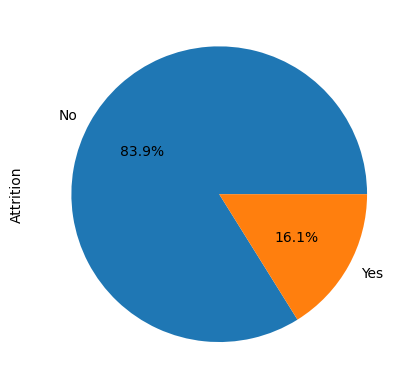

In [8]:
import matplotlib.pyplot as plt
y = df_encoded['Attrition']
counts = y.value_counts()

counts.plot(kind='pie', labels=['No', 'Yes'], autopct='%1.1f%%')
plt.show()

이러한 경우에 취할 수 있는 가장 간단한 조치는 Balanced sampling입니다. 즉, target 변수 y의 클래스 비율에 맞추어 층화추출하여 Trainset과 Testset의 y 클래스가 일치하도록 하는 것 입니다. 아래와 같이 전체 1470개의 record 중 90%를 trainset에 나머지 10%를 testset으로 분할하였으며, 각각의 데이터셋에서 target변수 클래스의 비율도 약 16%로 일치합니다.

In [9]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = df_encoded.drop('Attrition', axis=1)

# split dataset into train, dev, and test sets
# balanced sampling with respect to y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1123, stratify = y)

y_train.value_counts()

0    1110
1     213
Name: Attrition, dtype: int64

In [10]:
y_test.value_counts()

0    123
1     24
Name: Attrition, dtype: int64

# Fit XGBoost without Any Treatment

Imbalanced class issue에 대한 추가 조치를 취하기 전에 우선 XGBoost 모델을 적합한 뒤 모형의 분류 성능을 알아보도록 하겠습니다. XGBoost는 Boosted tree 알고리즘을 기반으로 한 머신러닝 모델의 일종입니다. 여기서 Boosted tree란 여러 개의 의사 결정 나무를 결합하여 보다 정확한 예측을 수행하는 앙상블 기계 학습 방법입니다. 예를 들어, 크기가 m인 trainset을 적합한다고 할 때, Boosted tree 알고리즘은 sampling with replacement를 통해 크기가 m인 또 하나의 유사한 데이터셋을 만듭니다. 그 후, 의사 결정 나무 하나를 적합한 뒤 해당 모형을 평가하고 모형에서 잘못 분류된 example에 더 많은 가중치를 부여하여 또다른 trainset을 복원추출로 생성합니다. 따라서 두 번째 trainset을 만들 때, 첫 번째 의사 결정 나무에서 잘못 분류된 record가 선택될 가능성이 높아집니다. 이러한 순차적인 학습 방식에서 다음 나무 모형은 이전 모형에서 실패한 record에 집중하여, 각 모형이 이전 모형의 오류를 수정합니다. XGBoost는 여기서 한 발 더 나아가서, 각각의 의사 결정 나무 모형이 가질 수 있는 feature의 갯수에 일부 패널티를 부여하는 방식으로 과적합을 방지합니다.

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb

# fit a XGBoost classifier on the training set
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1123)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1123, ...)

In [12]:
xgb_model.score(X_train, y_train)

1.0

첫번째 시도에서 XGBoost는 trainset을 완벽하게 fitting하였고 testset에서는 약 92%의 분류율을 보여주었습니다.

In [13]:
y_pred = xgb_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Test Accuracy: ", acc)
print("Test Confusion Matrix:\n ", cm)

Test Accuracy:  0.9183673469387755
Test Confusion Matrix:
  [[121   2]
 [ 10  14]]


하지만, testset에 대한 confusion matrix를 살펴보면, 전체 24명의 실제 퇴사자 중 모형이 정확하게 분류한 것은 14명에 불과하다는 것을 알 수 있습니다. 이는 target 변수의 class 분포에서 기인합니다. Raw data에서 전체 1470개의 record 중, 퇴사를 한 경우는 약 84%입니다. 따라서 예컨데, 어떠한 머신 러닝 모형을 적합하지 않고 무조건 "퇴사하지 않는다"라고 하여도 (즉, 단순히 ```print(0)```로 적합하여도), 84%의 데이터를 올바르게 분류할 수 있습니다. 하지만 이러한 분류에서는 미리 퇴사자를 분류하고 퇴사율을 낮출 수 있는 어떠한 인사이트도 발견할 수 없습니다. 

첫번째 시도에서 XGBoost는 약 84%의 벤치마크 점수를 넘었으므로 분류율이 일부 향상되었다고는 할 수 있지만, 데이터 분석의 목표를 고려할 때, False Negative (실제 퇴사자이지만, 근무 중인 직원으로 분류)인 케이스를 낮추는 것이 더욱 중요하다고 할 수 있겠습니다. 머신러닝에서 **Recall score**는 모형이 이러헌 False Negative를 최소화 하는지 판정할 수 있는 좋은 기준입니다. Recall score는 $\frac{\text{True Positive}}{\text{True Positive + False Negative}}$로 정의 됩니다. 머신러닝 모형이 False Negative를 적게 만들어낼수록 1에 가까운 recall score를 볼 수 있습니다. 아래에서 볼 수 있듯, 현재의 XGBoost 모형의 recall score는 0.6 이하 입니다.

In [14]:
from sklearn.metrics import recall_score

recall_score(y_test, y_pred)

0.5833333333333334

# XGBoost with Undersampling

Undersampling은 imbalanced class 이슈에 적용할 수 있는 한가지 방법입니다. Unsersampling에서는 class 분포가 치우친 분류 데이터셋에서 다수 class(더 많은 record를 가진 class)의 일부를 제거합니다. 이 때, undersampling은 testset이 아닌 trainset에만 적용해야 합니다. Undersampling은 다수 클레스에서 유용한 data point를 제거할 위험이 있기 때문에 모형이 underfitting 될 가능성이 있지만, 반대로 과적합의 위험을 줄일 수 있고 계산 비용도 적다는 장점이 있습니다. 아래에서 코드에서 무작위 undersampling을 통해 trainset의 근무자 1110개의 record (```Attrition == 0```) 중 일부가 무작위로 제거되어 class의 분포가 50:50으로 조정 되었음을 확인할 수 있습니다.

In [15]:
from imblearn.under_sampling import RandomUnderSampler

# perform random undersampling
ru = RandomUnderSampler(random_state = 1123)
X_undersampled, y_undersampled = ru.fit_resample(X_train, y_train)

# check the new class distribution
attrition_result, counts = np.unique(y_undersampled, return_counts=True)

print(dict(zip(attrition_result, counts)))

{0: 213, 1: 213}


In [16]:
# fit a XGBoost classifier on the oversampled training set
under_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1123)
under_model.fit(X_undersampled, y_undersampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1123, ...)

Undersampling을 적용한 후, XGBoost 모형을 적합한 뒤 testset에서의 분류 성능을 살펴보겠습니다. 아래에서 확인할 수 있듯, 전체적인 test 정확도는 92%에서 78%로 다소 낮아진 점을 확인할 수 있습니다. 이는 benchmark score인 84%보다도 낮은 성적입니다. 하지만 모형의 recall score는 0.83으로 이전의 0.58에 비해 비약적으로 증가하였다는 것을 알 수 있습니다. 따라서 HR 부서에서 Undersampling을 이용한 XGBoost 모형을 사용한다면, 전체 24명의 퇴사자중 20명을 정확하게 발견할 수 있고, 퇴사가 예상되는 직원을 미리 발견하여 효과적으로 퇴사율을 낮출 수 있습니다.

In [17]:
y_underpred = under_model.predict(X_test)

under_acc = accuracy_score(y_test, y_underpred)
under_cm = confusion_matrix(y_test, y_underpred)

print("Test Accuracy: ", under_acc)
print("Test Confusion Matrix:\n ", under_cm)

Test Accuracy:  0.782312925170068
Test Confusion Matrix:
  [[95 28]
 [ 4 20]]


In [18]:
recall_score(y_test, y_underpred)

0.8333333333333334

# LIME

다음으로 임의의 퇴사자에 대해 모형이 어떤 설명을 제공할 수 있는지 살펴보겠습니다. LIME은 XAI method의 일종으로, 개별 record의 분류에 대한 지역적 설명을 제공합니다. LIME의 핵심 아이디어는 관심있는 특정 record를 설명할 수 있는 로컬 선형 회귀 모델을 생성하여 모형이 해당 record를 분류한 이유를 설명하는 것입니다. LIME을 사용할 때 일반적으로 다음과 같은 단계를 거칩니다:

 1. Sampling 및 Surrogate 데이터 생성: 설명하려는 record 주변의 데이터를 샘플링하여 해당 record를 설명할 수 있는 Surrogate 데이터 세트를 생성합니다.
 2. Sparse linear model 학습: L1 Regularization을 사용하여 Surrogate 데이터 세트에 대한 선형 모델을 적합합니다.
 3. Sparse linear model 해석: 선형 모델을 사용하여 원래 모델의 예측을 원래 인스턴스의 특징으로 설명합니다.
   
여기서 surrogate 데이터란, 더 간단한 지역 모델을 훈련하는 데 사용되는 인공적으로 생성된 데이터 포인트 세트를 말합니다. Surrogate 데이터 생성에는 원래 데이터를 증강하여 새로운 목표 라벨이 있는 데이터 포인트를 생성하는 것이 포함됩니다. 따라서 LIME 모형은 관심있는 데이터 포인트와 비슷한 feature value를 갖는 데이터셋을 생성한 후 해당 데이터셋에 대해 선형 모형을 적합하여 회귀 계수를 통해 설명력을 제공합니다.

전체 데이터셋에서 임의로 415번 record를 살펴보겠습니다. 해당 record는 실제 퇴사한 직원의 자료이며, 모형은 정확하게 직원의 퇴사를 분류하였습니다.

In [19]:
# classify single instance
anon_pred = under_model.predict(X.iloc[[415]]) 
anon_attrition = y.iloc[415]

# print predicted label and true label for the instance
print("Predicted label:", anon_pred[0])
print("True label:", anon_attrition)

Predicted label: 1
True label: 1


해당 직원의 feature value는 아래와 같습니다.

In [20]:
X.iloc[415]

Age                                    34.0
BusinessTravel                          1.0
DistanceFromHome                        6.0
Education                               2.0
EnvironmentSatisfaction                 4.0
Gender                                  0.0
JobInvolvement                          1.0
JobLevel                                1.0
JobSatisfaction                         3.0
MonthlyIncome                        2351.0
NumCompaniesWorked                      0.0
OverTime                                0.0
PercentSalaryHike                      16.0
PerformanceRating                       3.0
RelationshipSatisfaction                4.0
StockOptionLevel                        1.0
TotalWorkingYears                       3.0
TrainingTimesLastYear                   3.0
WorkLifeBalance                         2.0
YearsAtCompany                          2.0
YearsInCurrentRole                      2.0
YearsSinceLastPromotion                 1.0
YearsWithCurrManager            

In [21]:
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import Lasso

# create Lasso model
lasso_model = Lasso(alpha=0.01)

# create explainer
explainer = LimeTabularExplainer(X.values, feature_names=X.columns, class_names=y.unique(), discretize_continuous=False)

# explain prediction using Lasso as local surrogate model
instance = X.iloc[[415]]
explanation = explainer.explain_instance(instance.values[0], xgb_model.predict_proba, num_features=10, model_regressor=lasso_model)

# print feature weights and scores
print(explanation.as_list())

[('OverTime', 0.050078664306556823), ('MonthlyIncome', -0.029933054389332213), ('JobInvolvement', -0.020156096419697483), ('EnvironmentSatisfaction', -0.019792438259200976), ('TotalWorkingYears', -0.016296166557392324), ('NumCompaniesWorked', 0.013492595075510492), ('WorkLifeBalance', -0.006626451151311692), ('JobRole_Sales Representative', 0.0), ('EducationField_Marketing', 0.0), ('Gender', 0.0)]


LIME을 적용하였을 때, 회귀계수는 위와 같습니다. 회귀계수의 해석은 로지스틱 회귀분석에서와 마찬가지입니다. 예를 들어, 해당 근무자와 유사한 feature value를 갖는 데이터에서 추가근무를 하는 경우 (```OverTime``` 0 to 1), 직원이 퇴사할 Odds가 평균적으로 약 4% 증가하고, 급여가 1단위 증가할 때 직원이 퇴사할 Odds는 평균적으로 약 3% 감소 합니다 (다른 모든 feature value는 고정). 

415번 직원의 경우 추가 근무를 하지 않았습니다 (```OverTime == 0```). 따라서, 모형의 결과를 바탕으로 급여의 인상을 제안할 수 있습니다.

In [22]:
print(np.exp(0.04075730676554104)) # Overtime
print(np.exp(-0.02778255525825031)) # Monthly income

1.0415992857682226
0.9725998305285509


# SHAP
## Shapley Value와 협력 게임

협력게임은 게임 이론의 한 분야로, 게임에서 참가자들은 연합을 이루어 공통의 목표를 달성하기 위해 노력합니다. 협력 게임에서 각 멤버들의 가능한 조합마다 협력 결과를 측정한 뒤, 각 참가자의 marginal contribution과 Shapley value를 계산하여 실제 팀워크에서 각 참가자의 기여도를 계산합니다. 기계학습에서 marginal contribution과 Shapley value라는 개념은 모델 내에서 feature가 어떻게 결과에 영향을 미치는지 측정하는 데 적용될 수 있습니다. 예를 들어, x1, x2, 그리고 x3라는 세 가지 피쳐를 가진 "블랙박스 모델"이 있다고 가정해봅시다. 이 모델은 feature들의 가능한 조합 각각에 대한 예측을 수행합니다. 이 모델에서 각 feature의 marginal contribution과 Shapley value는 각 모델의 예측 결과에 따라 측정됩니다.

|Model|x1|x2|x3|Outcome|
|---|---|---|---|---|
|m1|False|False|False|28|
|m2|True|False|False|32|
|m3|False|True|False|31|
|m4|False|False|True|30|
|m5|True|True|False|32|
|m6|True|False|True|33|
|m7|False|True|True|32|
|m8|True|True|True|35|

x1의 marginal contribution을 살펴보겠습니다. 하나의 feature만을 가진 모델에서, x1이 포함된 m2와 x1이 포함되지 않은 m1의 결과 차이가 4이므로, 하나의 특성만을 가진 모델에서의 x1의 marginal contribution는 4입니다. 다음으로, x1이 포함된 두 개의 이중 feature 모델이 있습니다 (m5와 m6). m5에서 x1을 제외하면 m3이 되고, 결과의 차이는 32-31=1입니다. 마찬가지로 m6에서 x1을 제외하면 결과는 3이 달라집니다. 마지막으로, 전체 모델 m8에서 x1을 제외하면 결과는 3이 달라집니다. 이것은 m7의 결과를 m8의 결과에서 빼면 얻을 수 있습니다. 따라서, x1의 marginal contribution는 다음과 같습니다.

 * 단일 feature 모델: m2 - m1 = 4
 * 이중 feature 모델: m5 - m3 = 1
 * 이중 feature 모델: m6 - m4 = 3
 * 삼중 feature 모델: m8 - m7 = 3

각 경우의 x1 marginal contribution으로부터, 가중합을 통해 Shapley value를 얻을 수 있습니다. 예를 들어, 3개의 단일 feature 모델 중, x1을 제외할 수 있는 경우는 1개뿐입니다. 따라서, 단일 피쳐 모델에서 x1의 마진 기여도에 대한 가중치는 1/3입니다. 마찬가지로 이중 feature 모델은 총 3개가 있고, 각 모델마다 2개의 Fueature 중 하나를 제외할 수 있습니다. 이 경우, x1의 마진 기여도에 대한 가중치는 1/6입니다. 즉, 모델이 3개이며 각 모델 내에서 2개의 가능한 제외가 있기 때문에 $1/3 \times 1/2$입니다. 마지막으로, 전체 모델은 1개뿐이며 모델 내에서 3개의 가능한 제외가 있습니다. 따라서 가중치는 $1 \times 1/3$입니다. 따라서 feature x1의 Shapley value는 다음과 같습니다.

$$
4 \ast \frac{1}{3} + 1 \ast \frac{1}{6} + 3 \ast \frac{1}{6} + 3 \ast \frac{1}{3}
$$

$i$ 번째 feature의 Shapley 값을 $\phi$, $i$번째 feature를 제외한 feature 집합을 $S$, 모든 feature를 포함한 전체 집합을 $F$라고 할 때, Shapley value의 정의는 아래와 같습니다.

$$
\phi_i = \sum_{S \subseteq F/\{i\}}\frac{|S|!\ast(|F| - |S| - 1)!}{|F|!} \ast (f(S \cup \{i\}) - f(S))
$$

## SHapley Additive exPlanations

SHAP (SHapley Additive exPlanations)는 Shapley 값을 기반으로 하는 머신러닝 모델 해석의 프레임워크입니다. SHAP는 kernel 기반 또는 tree 기반 접근 방식을 사용하여 각 feature의 Shapley 값을 추정하고 모델의 출력을 설명하기 위해 이들을 집계합니다. SHAP가 기존의 Shapley value와 구분되는 점은, Shapley value가 머신러닝 모델을 전체적으로 보았을 때 어떤 feature가 중요한지 만을 측정하는데 반해, SHAP에서는 LIME에서와 같이 개별 예측값의 지역적 설명 또한 제공한다는 점 입니다.

기계 학습 모델에서 **지역 설명**은 기계 학습 모델에 의한 개별 예측값을 설명하는 것을 의미합니다. 다시 말해, 지역 설명은 특정 입력 record가 모델에 의해 어떻게 분류되었는지를 설명함으로써 그것이 어떻게 예측되었는지를 각 feature의 기여도로 해석하는 것입니다. SHAP의 맥락에서 지역 설명은 Shapley 값의 형태로 제공되며, 이는 각 기능이 특정 입력 인스턴스에 대한 예측에 기여한 정도를 나타냅니다. 각 feature의 Shapley 값이 계산되면, SHAP는 특정 입력 record에 대해 모델이 어떻게 예측했는지에 대한 상세한 설명을 제공할 수 있습니다.

반면에, 전체 데이터셋에서 모델의 동작과 성능을 이해하는 것을 전역 모델 인사이트라고 합니다. SHAP는 우선 지역 설명을 통해 데이터셋의 모든 record에 대해 feature 중요도 점수 (각 feature의 Shapley 값 점수)를 계산한뒤, Shapley value들의 평균값을 계산하여 모델의 가장 중요한 feature를 전반적으로 순위를 매기는 것으로 이를 제공할 수 있습니다. 이는 모델의 출력에 가장 큰 영향을 미치는 feature를 식별하고 feature와 target 변수 간의 관계에 대한 인사이트를 제공하는 데 도움이 될 수 있습니다. 

In [23]:
import shap

feature_names = X.columns
xgb_explainer = shap.Explainer(under_model, X)
shap_values = xgb_explainer(X)
shap_values.shape

(1470, 44)

아래의 차트는 SHAP에 의한 전역 설명력을 제공합니다. 차트에서 각각의 점들은 각각의 record를 나타내고, 색깔은 해당 인스턴스에 대한 각각의 feature value를 나타냅니다. 색깔이 붉은 색에 가까울수록 feature value가 높다는 것을 의미합니다. 예를들어 OverTime은 0과 1의 두 가지 값을 가지는데, 해당 근무자가 연장근무를 한 경우 붉은색, 아닌 경우 푸른색으로 표시 됩니다. 마찬가지로 통근 거리가 멀수록 붉은 색, 가까울수록 푸른 색에 가깝게 표시됩니다. 반면, 차트의 가로축은 Shapley value의 크기를 나타냅니다. 어 떤 점이 오른쪽 혹은 왼쪽으로 많이 치우친 경우, 그 점의 해당 feature가 가지는 영향력이 매우 큰 것을 나타냅니다. 반면에 점의 위치가 0에 가까울수록 해당 record에는 특정 feature가 가지는 영향력이 없음을 뜻합니다.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


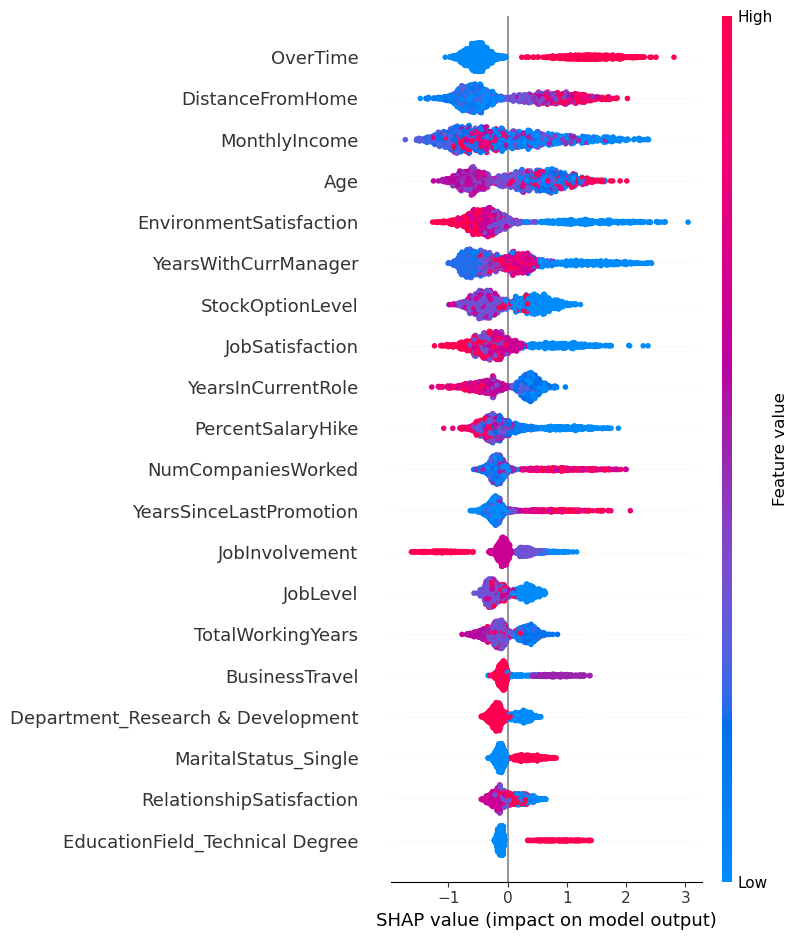

In [24]:
shap.summary_plot(shap_values, X, feature_names=feature_names)


다음으로 앞서 살펴보았던 415번 직원의 shapley value를 살펴보겠습니다. 아래의 attribute들은 각각 해당 직원의 각 feature에 대한 Shapley value, baseline expectation, input feature value를 나타냅니다. 여기서 baseline expectation은 모든 feature input이 평균일 때, 모형이 예측하는 직원의 퇴사 odds를 뜻합니다.

In [25]:
shap_values[415]

.values =
array([-0.00265621,  0.89979528, -0.53600715,  0.00533195, -0.20014329,
       -0.1988162 ,  0.55053781,  0.48552151,  0.06972035,  2.22206356,
       -0.08997799, -0.72945798,  0.12743617,  0.        ,  0.0450389 ,
       -0.24209995,  0.15761461,  0.02988354,  0.20228182,  0.08230512,
        0.32788604, -0.03605989,  1.56736698,  0.00373404,  0.2080944 ,
        0.470154  ,  0.        ,  0.06867883,  0.00360456,  0.15165364,
        0.        , -0.10215649,  0.00339815,  0.        , -0.01970324,
        0.02036034, -0.00801831,  0.        ,  0.05768735, -0.09344533,
        0.        , -0.04410774,  0.3911476 , -0.19278614])

.base_values =
-1.1700946584058876

.data =
array([3.400e+01, 1.000e+00, 6.000e+00, 2.000e+00, 4.000e+00, 0.000e+00,
       1.000e+00, 1.000e+00, 3.000e+00, 2.351e+03, 0.000e+00, 0.000e+00,
       1.600e+01, 3.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 3.000e+00,
       2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00,

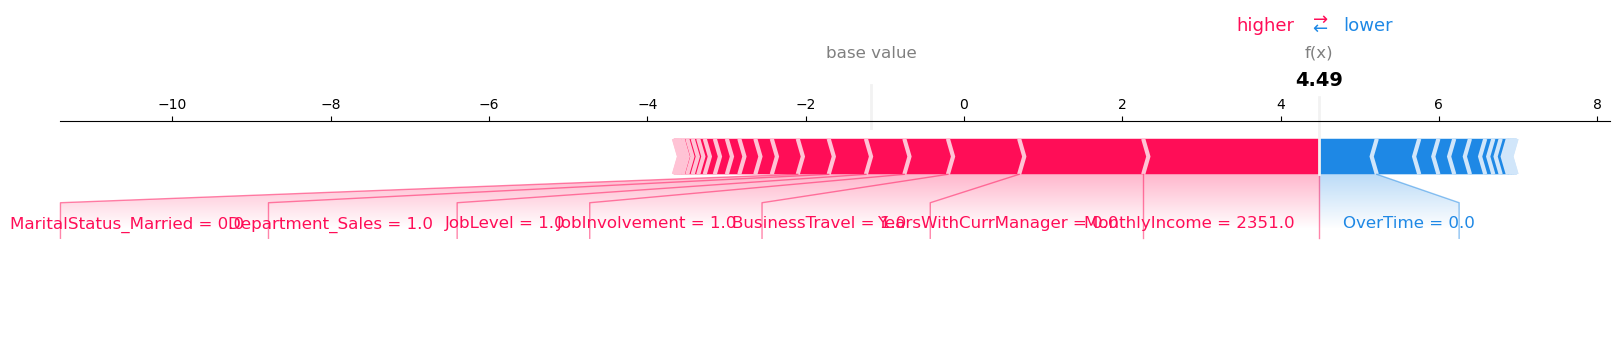

In [26]:
from IPython.core.display import HTML
import matplotlib.pyplot as plt

def initjs():
    display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/codemirror/5.13.4/codemirror.min.js'></script>"))

# create Explanation object for the instance at index 415
inst = X.iloc[415]
exp_value = xgb_explainer.expected_value
shap_values_inst = xgb_explainer(inst)
explanation = shap.Explanation(values = shap_values[415].values, # shapley values
                               base_values = xgb_explainer.expected_value, # baseline
                               data = X.iloc[415], 
                               feature_names = feature_names)
                               
# call initjs() before using shap.force_plot()
initjs()
shap.force_plot(explanation.base_values, 
                shap_values[415].values, 
                inst, 
                feature_names = explanation.feature_names,
                matplotlib = True)

위의 그래프를 보았을 때, 해당 직원이 퇴사를 하도록 결심했을 것으로 추정되는 요인으로는 급여, 현재 관리자와의 근무 년 수 등이 있으며, 반대로 그녀가 퇴사하는 것을 망설였을 요인으로는 연장근무가 없다는 사실이었음을 확인할 수 있습니다. 